### TokaMaker Example: Simple equilibrium reconstruction in DIII-D {#doc_tMaker_DIIID_ex3}
==========
In this example we show how to perform an equilibrium reconstruction in DIII-D.

This example utilizes the mesh built in \ref doc_tMaker_DIIID_ex1.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) python package, which is installable using `pip` or other standard methods.

**Warning:** The reconstruction functionality in TokaMaker is still a work in progress, as the PSI-Tri capabilities are activated and tested. Please use with care.

In [1]:
import os
import sys
import random
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit import OFT_env
from OpenFUSIONToolkit.TokaMaker import TokaMaker
from OpenFUSIONToolkit.TokaMaker.meshing import load_gs_mesh
from OpenFUSIONToolkit.TokaMaker.reconstruction import reconstruction
from OpenFUSIONToolkit.TokaMaker.util import create_power_flux_fun, create_isoflux

## Initialize TokaMaker object
We now create a \ref OpenFUSIONToolkit.OFT_env "OFT_env" instance for execution using two threads and a \ref OpenFUSIONToolkit.TokaMaker.TokaMaker "TokaMaker" instance to use for equilibrium calculations. Note at present only a single `TokaMaker` instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [3]:
myOFT = OFT_env(nthreads=2)
mygs = TokaMaker(myOFT)

# Update maximum number of solver iterations
mygs.settings.maxits=250
mygs.update_settings()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   sol-currents
Revision id:          c8f2570
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = /var/folders/qz/wcp9q1mj0c5fsyjtbt99bvhh0000gn/T/oft_98381/oftpyin
XML input file        = none
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



## Load mesh into TokaMaker
Now we load the mesh generated in \ref doc_tMaker_DIIID_ex1 using \ref OpenFUSIONToolkit.TokaMaker.load_gs_mesh "load_gs_mesh()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_mesh "setup_mesh". Then we use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_regions "setup_regions()", passing the conductor and coil dictionaries for the mesh, to define the different region types. Finally, we call \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup "setup()" to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4) and the toroidal field through F0 = B0*R0, where B0 is the toroidal field at a reference location R0.

In [4]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('DIIID_files/DIIID_mesh.h5')
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order = 2, F0 = 3.246)


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  1.574E+01
    # of points  =    8910
    # of edges   =   26567
    # of cells   =   17658
    # of boundary points =     160
    # of boundary edges  =     160
    # of boundary cells  =     160
  Resolution statistics:
    hmin =  8.702E-04
    hrms =  4.833E-02
    hmax =  1.540E-01
  Surface grounded at vertex    1733


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    2.2759999999999998E-003


At line 6249 of file /Users/johnl/Desktop/OpenFUSIONToolkit/src/physics/grad_shaf.F90
Fortran runtime warning: An array temporary was created for argument 'b' of procedure 'mat_add_values'
At line 6253 of file /Users/johnl/Desktop/OpenFUSIONToolkit/src/physics/grad_shaf.F90
Fortran runtime warning: An array temporary was created for argument 'b' of procedure 'mat_add_values'


## Define hard limits on coil currents
Hard limits on coil currents can be set using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_coil_bounds "set_coil_bounds()". In this case we just the simple and approximate bi-directional limit of 5 MA in each coil.

Bounds are specified using a dictionary of 2 element lists, containing the minimum and maximum bound, where the dictionary key corresponds to the coil names, which are available in \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.coil_sets "mygs.coil_sets"

In [5]:
coil_bounds = {key: [-5.E6, 5.E6] for key in mygs.coil_sets}
mygs.set_coil_bounds(coil_bounds)

## Define vertical stability coils

In [6]:
vsc_signs = {key: 0 for key in mygs.coil_sets}
vsc_signs['F9A'] = 1.0
vsc_signs['F9B'] = -1.0
mygs.set_coil_vsc(vsc_signs)

## Compute Equilibrium for Reconstruction

### Define global quantities and targets
For the inverse case we define a target for the plasma current and the peak plasma pressure, which occurs on the magnetic axis.

**Note:** These constraints can be considered "hard" constraints, where they will be matched to good tolerance as long as the calculation converges.

In [7]:
Ip_target=493324.5
P0_target=6831.64
mygs.set_targets(Ip=Ip_target, pax=P0_target)

### Define shape targets
In order to constrain the shape of the plasma we can utilize two types of constraints:
 1. `isoflux` points, which are points we want to lie on the same flux surface (eg. the LCFS)
 2. `saddle` points, where we want the poloidal magnetic field to vanish (eg. X-points). While one can also use this constraint to enforce a magnetic axis location, instead \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_targets "set_targets()" should be used with arguments `R0` and `V0`.

**Note:** These constraints can be considered "soft" constraints, where the calculation attempts to minimize error in satisfying these constraints subject to other constraints and regularization.

Here we use the create_isoflux function to define a target LCSF for the equilibrium.

In [8]:
isoflux_pts = np.array([
     [1.16865048, -0.025],
     [1.2384375, 0.215289199],
     [1.35653398, 0.375],
     [1.48305544, 0.5],
     [1.62359375, 0.604215274],
     [1.78296875, 0.684033046],
     [1.96890625, 0.718502945],
     [2.11614326, 0.625],
     [2.20796875, 0.407861997],
     [2.27774514, 0.175],
     [2.274375, -0.145553939],
     [2.20755583, -0.375],
     [2.1415625, -0.632614721],
     [2.061875, -0.80090522],
     [1.9025, -0.749168426],
     [1.74116244, -0.675],
     [1.58375, -0.575838396],
     [1.4509375, -0.466367354],
     [1.318125, -0.326210986],
     [1.211875, -0.169044417]
])

mygs.set_isoflux(isoflux_pts)

### Define coil regularization matrix
In general, for a given coil set a given plasma shape cannot be exactly reproduced, which generally yields large amplitude coil currents if no constraint on the coil currents is applied. As a result, it is useful to include regularization terms for the coils to balance minimization of the shape error with the amplitude of current in the coils. In TokaMaker these regularization terms have the general form, where each term corresponds to a set of coil coefficients, target value, and weight. The \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.coil_reg_term "coil_reg_term()" method is provided to aid in defining these terms.

In this case, one regularization term is added for each coil with a single unit coefficient for that coil and target of zero with modest weights. This regularization acts to penalize the amplitude of current in each coil, acting to balance coil current with error in the shape targets.

Note that both classes of coils are treated the same in this example; however they could be given different weights if so desired. 

In [9]:
coil_reg_mat = np.eye(mygs.ncoils+1, dtype=np.float64)
coil_reg_weights = np.ones((mygs.ncoils+1,))
coil_reg_targets = np.zeros((mygs.ncoils+1,))
 
# Set regularization weights
for key, coil in mygs.coil_sets.items():
    if key.startswith('ECOIL'):
        coil_reg_weights[coil['id']] = 2.E-2
    elif key.startswith('F'):
        coil_reg_weights[coil['id']] = 1.E-2

# Set weight for VSC virtual coil
coil_reg_weights[-1] = 1.E2
 
# Pass regularization terms to TokaMaker
mygs.set_coil_reg(coil_reg_mat, reg_weights=coil_reg_weights, reg_targets=coil_reg_targets)

### Define flux functions
Although TokaMaker has a "default" profile for the F\*F' and P' terms this should almost never be used and one should instead choose an appropriate flux function for their application. In this case we use an L-mode-like profile of the form $((1-\hat{\psi})^{\alpha})^{\gamma}$, using \ref OpenFUSIONToolkit.TokaMaker.util.create_power_flux_fun "create_power_flux_fun()", where $\alpha$ and $\gamma$ are set differently for F\*F' and P' to provide peaked and broad profiles respectively. Within TokaMaker this profile is represented as a piecewise linear function, which can be set up using the dictionary approach shown below.

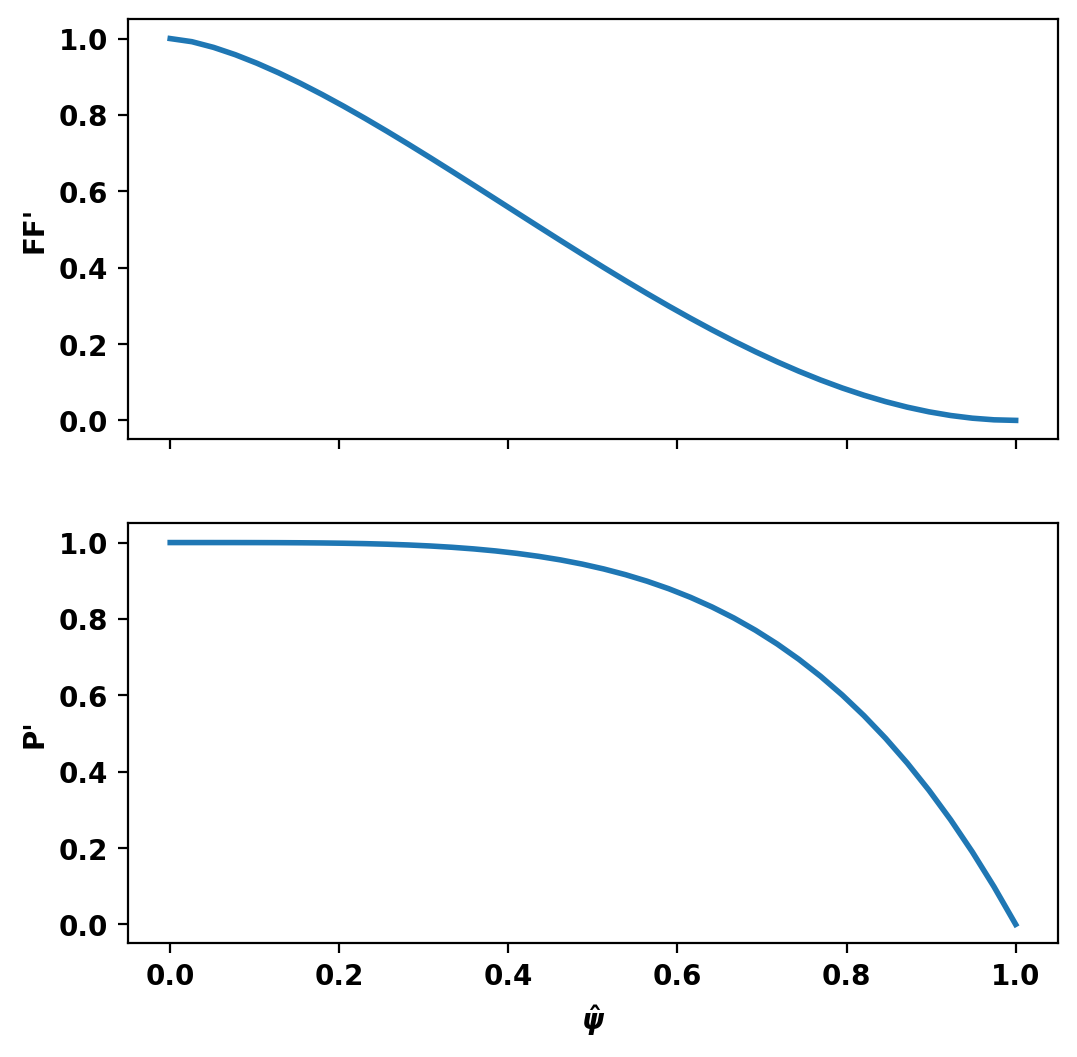

In [10]:
# Set profiles
ffp_prof = create_power_flux_fun(40,1.5,2.0)
pp_prof = create_power_flux_fun(40,4.0,1.0)

fig, ax = plt.subplots(2,1,sharex=True)
# Plot F*F'
ax[0].plot(ffp_prof['x'],ffp_prof['y'])
ax[0].set_ylabel("FF'")
# Plot P'
ax[1].plot(pp_prof['x'],pp_prof['y'])
ax[1].set_ylabel("P'")
_ = ax[-1].set_xlabel(r"$\hat{\psi}$")

mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=pp_prof)

plt.show()

### Compute equilibrium
We can now compute a free-boundary equilibrium using these constraints. Note that before running a calculation for the first time we must initialize the flux function $\psi$, which can be done using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.init_psi "init_psi()". This subroutine initializes the flux using the specified Ip_target from above, which is evenly distributed over the entire plasma region or only with a boundary defined using a center point (R,Z), minor radius (a), and elongation and triangularity. Coil currents are also initialized at this point using the constraints above and this uniform plasma current initialization. 

\ref OpenFUSIONToolkit.TokaMaker.TokaMaker.solve "solve()" is then called to compute a self-consitent Grad-Shafranov equilibrium. If the result variable (`err_flag`) is zero then the solution has converged to the desired tolerance ($10^{-6}$ by default).

In [11]:
R0 = 1.7
Z0 = 0.0
a = 0.5
kappa = 1.3
delta = 0.4

mygs.init_psi(R0, Z0, a, kappa, delta)
mygs.solve()

At line 2230 of file /Users/johnl/Desktop/OpenFUSIONToolkit/src/physics/grad_shaf.F90
Fortran runtime warning: An array temporary was created


Starting non-linear GS solver
     1  7.6720E-01  2.6841E-01  1.3674E-02  1.8398E+00  9.8159E-04  3.7975E-04
     2  2.9600E+00  1.2083E-01  1.2380E-02  1.8253E+00  5.9022E-04  9.5750E-05
     3  3.8036E+00  9.0847E-02  1.0755E-02  1.8186E+00  5.6972E-04 -3.6488E-05
     4  4.2004E+00  8.0484E-02  6.4218E-03  1.8151E+00  6.7352E-04 -9.3189E-05
     5  4.3940E+00  7.6286E-02  3.4679E-03  1.8132E+00  8.0332E-04 -1.1892E-04
     6  4.4898E+00  7.4431E-02  1.8156E-03  1.8121E+00  9.0802E-04 -1.3128E-04
     7  4.5375E+00  7.3568E-02  9.3979E-04  1.8114E+00  1.0072E-03 -1.3748E-04
     8  4.5613E+00  7.3154E-02  4.8396E-04  1.8110E+00  1.0804E-03 -1.4066E-04
     9  4.5731E+00  7.2953E-02  2.4848E-04  1.8108E+00  1.1323E-03 -1.4233E-04
    10  4.5789E+00  7.2854E-02  1.2732E-04  1.8107E+00  1.1680E-03 -1.4323E-04
    11  4.5819E+00  7.2805E-02  6.5144E-05  1.8106E+00  1.1921E-03 -1.4372E-04
    12  4.5833E+00  7.2781E-02  3.3308E-05  1.8106E+00  1.2081E-03 -1.4399E-04
    13  4.5840E+00  7.

### Plot equilibrium
Flux surfaces of the computed equilibrium can be plotted using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_psi "plot_psi()" method. The additional plotting methods \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_machine "plot_machine()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_constraints "plot_constraints()" are also used to show context and other information. Each method has a large number of optional arguments for formatting and other options.

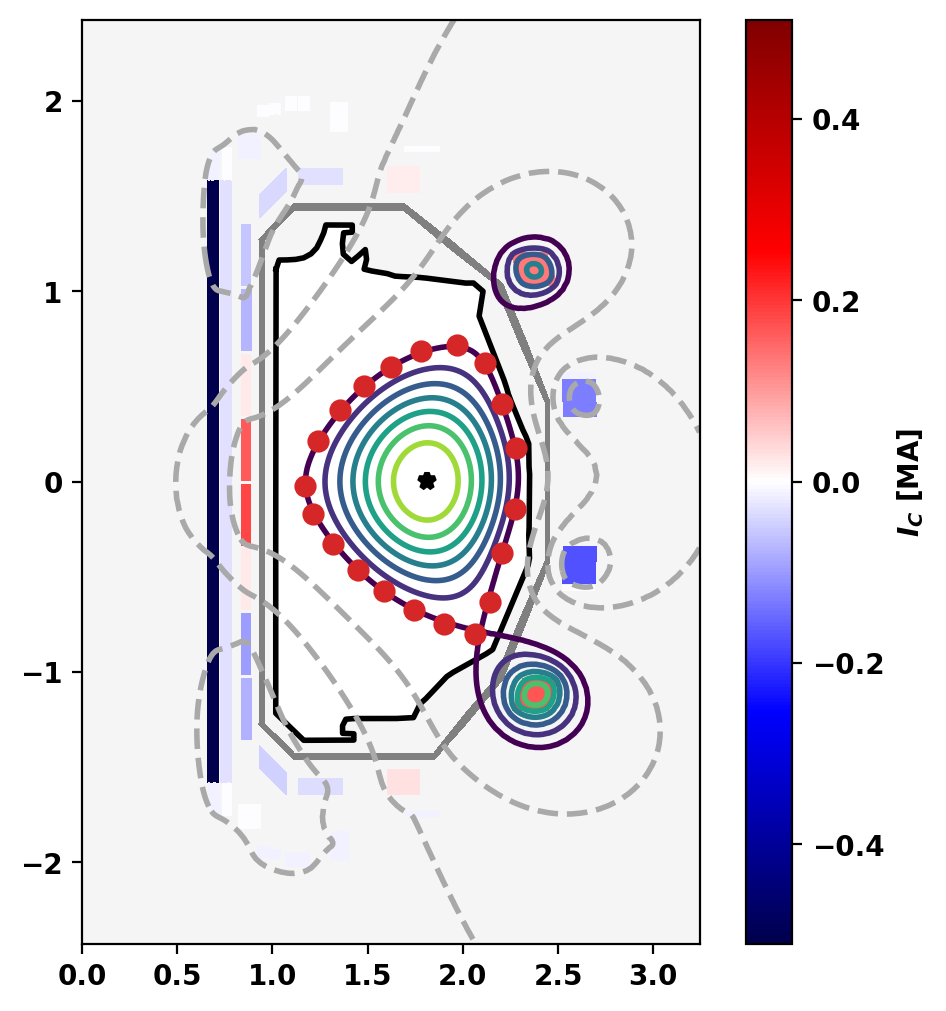

In [12]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_symmap=True,coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]')
mygs.plot_psi(fig,ax,xpoint_color=None,vacuum_nlevels=4)
mygs.plot_constraints(fig,ax,isoflux_color='tab:red',isoflux_marker='o')
psi_target = mygs.get_psi()
eq_target = mygs.get_stats()
plt.show()

### Print equilibrium information and coil currents
Basic parameters can be displayed using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.print_info "print_info()" method. For access to these quantities as variables instead the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_stats "get_stats()" can be used.

The final coil currents can also be retrieved using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_coil_currents "get_coil_currents()" method, which are all within the approximate coil limits imposed above.

In [13]:
mygs.print_info()
 
print()
print("Coil Currents [MA]:")
coil_currents, _ = mygs.get_coil_currents()
for key in mygs.coil_sets:
    print('  {0:10} {1:10.2F}'.format(key+":",coil_currents[key]/1.E6))

Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    4.9332E+05
  Current Centroid [m]    =    1.784 -0.000
  Magnetic Axis [m]       =    1.811  0.001
  Elongation              =    1.344 (U:  1.264, L:  1.424)
  Triangularity           =   -0.510 (U: -0.371, L: -0.648)
  Plasma Volume [m^3]     =   13.136
  q_0, q_95               =    1.465  4.439
  Peak Pressure [Pa]      =    6.8231E+03
  Stored Energy [J]       =    4.2710E+04
  <Beta_pol> [%]          =   22.2214
  <Beta_tor> [%]          =    0.1557
  <Beta_n>   [%]          =    0.3266
  Diamagnetic flux [Wb]   =    6.2172E-03
  Toroidal flux [Wb]      =    2.1928E+00
  l_i                     =    1.1560

Coil Currents [MA]:
  F1A:             0.16
  F2A:             0.02
  F3A:            -0.07
  F4A:            -0.06
  F5A:            -0.04
  F6A:            -0.13
  F7A:             0.13
  F8A:            -0.03
  F9A:             0.02
  F1B:             0.19
  F2B:             0.02
 

## Perform Reconstruction

### Create Reconstruction Object

In [14]:
myrecon = reconstruction(mygs)

### Define Helper Functions to Read Sensor Locations
For this example we load data representing flux loops and Mirnov sensor locations and orientations in DIII-D. The signals in these sensors will be used to constrain the reconstruction along with coil currents and global plasma quantities (eg. $I_p$). First we define two helper functions to read Flux Loop and Mirnov sensor configurations.

In [15]:
def read_points_flux(file_path,  sensor_names = None):
    points = OrderedDict()
    with open(file_path, 'r') as file:
        for line in file:
            if sensor_names is not None:
                name, r, z = line.strip().split()  # Split and ignore the first field (name)
                if name in sensor_names:
                    points[name] = [float(r),float(z)]
            else:
                name, r, z = line.strip().split()  # Split and ignore the first field (name)
                points[name] = [float(r),float(z)]
    return points
    
def read_points_mag(file_path, sensor_names = None):
    points = OrderedDict()
    with open(file_path, 'r') as file:
        for line in file:
            if sensor_names is not None: 
                name, r, z, pol, orient, _, _, _ = line.strip().split()  # Split and ignore the first field (name)
                if name in sensor_names:
                    points[name] = [float(r), float(z), float(orient)]
            else: 
                name, r, z, pol, orient, _, _, _ = line.strip().split()  # Split and ignore the first field (name)
                points[name] = [float(r), float(z), float(orient)]  # Convert r and z to floats and append
    return points

### Load Sensor Locations From Files

In [16]:
magSensors322 = read_points_mag('DIIID_files/3222magsensorloc.txt')
fluxLoops_onf = read_points_flux('DIIID_files/fcoil_fluxloops.txt')
fluxLoops_vv = read_points_flux('DIIID_files/vv_fluxloops.txt')

### Read Data From Equilibrium to Mirnov Probes

In [17]:
def convert_Mirnov_coordinates(sensor):
    pol_angle = 322
    R, z, gamma = sensor
    position = np.array([R, z]) 
    nx = np.cos(gamma*np.pi/180) 
    ny = 0
    nz = np.sin(gamma*np.pi/180)
    cosphi = np.cos(pol_angle*np.pi/180)
    sinphi = np.sin(pol_angle*np.pi/180)
    orientation = np.array([nx*cosphi - ny*sinphi, nx*sinphi - ny*cosphi, nz])
    return position, orientation

field_eval = mygs.get_field_eval('B')
for _, mag in magSensors322.items():
    position, orientation = convert_Mirnov_coordinates(mag)
    B_tmp = np.dot(field_eval.eval(position), orientation)
    noise_amp = (random.random()-0.5)*2.0
    myrecon.add_Mirnov(position, orientation, B_tmp + noise_amp*abs(B_tmp*0.05), err=abs(B_tmp*0.05))

### Read Data From Equilibrium to Flux Loops

In [18]:
flux_locs = []
flux_vals = []
field_eval = mygs.get_field_eval('PSI')

for _, fl in fluxLoops_onf.items():
    B_tmp = field_eval.eval(fl)
    noise_amp = (random.random()-0.5)*2.0
    flux_locs.append(fl)
    flux_vals.append(B_tmp[0])
    psi_val = B_tmp[0]*2.0*np.pi
    myrecon.add_flux_loop(fl, psi_val*(1.0 + noise_amp*0.05), err=abs(psi_val*0.05))

for _, fl in fluxLoops_vv.items():
    B_tmp = field_eval.eval(fl)
    noise_amp = (random.random()-0.5)*2.0
    flux_locs.append(fl)
    flux_vals.append(B_tmp[0])
    psi_val = B_tmp[0]*2.0*np.pi
    myrecon.add_flux_loop(fl, psi_val*(1.0 + noise_amp*0.05), err=abs(psi_val*0.05))

### Plot equilibrium and probe locations

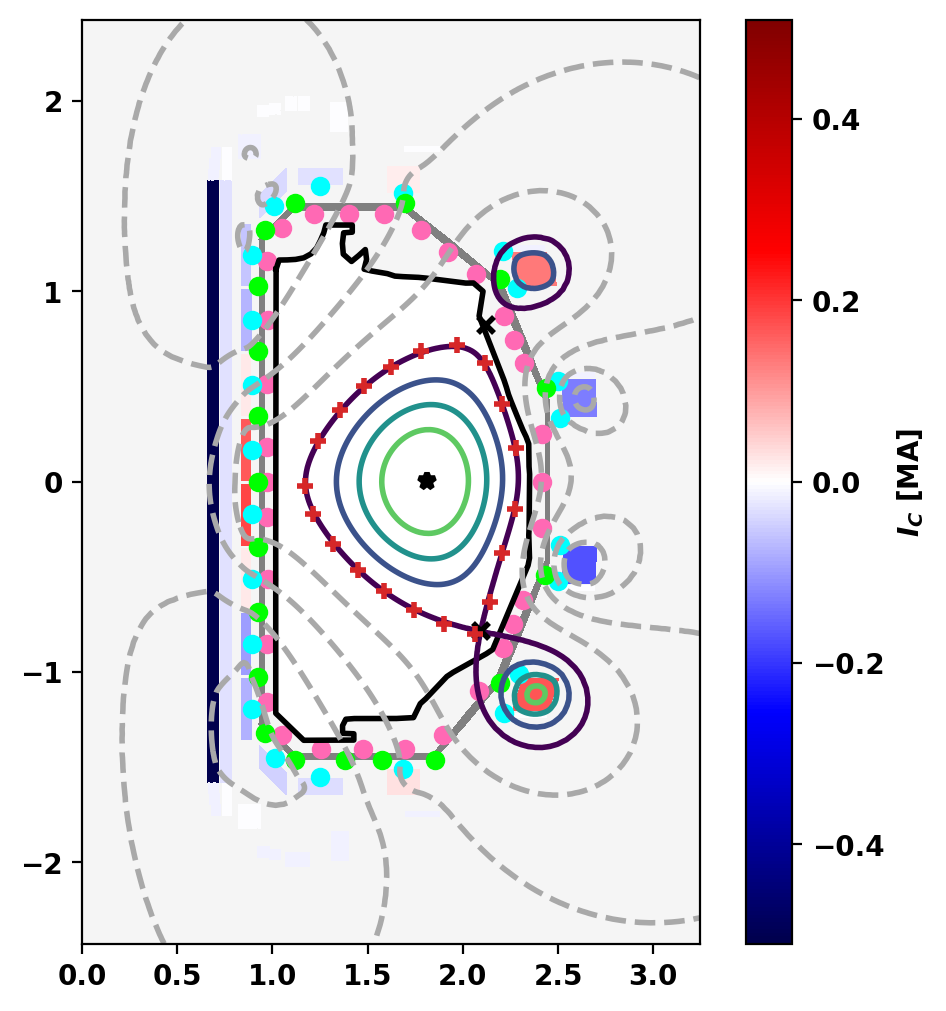

In [19]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]',coil_symmap=True)
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_constraints(fig, ax)

def plot_sensors(sensors, color):
    r_coords = [s[0] for _,s in sensors.items()]
    z_coords = [s[1] for _,s in sensors.items()]
    ax.scatter(x=r_coords, y=z_coords, color=color)

plot_sensors(magSensors322, color='hotpink')
plot_sensors(fluxLoops_onf, color='cyan')
plot_sensors(fluxLoops_vv, color='lime')

plt.show()

### Set plasma current constraint
First we define a constraint on the plasma current with 5% random noise added to the signal and an appropriate error. This constraint is equivalent to the measurement of a synthetic Rigowskii coil and can be set using \ref OpenFUSIONToolkit.TokaMaker.reconstruction.reconstruction.set_Ip "set_Ip()".

In [20]:
noise_amp = (random.random()-0.5)*2.0
Ip_noised = eq_target['Ip']*(1.0+noise_amp*0.05)
myrecon.set_Ip(Ip_noised, err=0.05*eq_target['Ip'])

### Add noise to coil currents

In [21]:
coil_currents, _ = mygs.get_coil_currents()
for key in coil_currents:
    noise_amp = (random.random()-0.5)*2.0
    coil_currents[key] *= 1.0+noise_amp*0.05

### Compute starting equilibrium

In [22]:
# Replace shape constraints with absolute flux and current constraints
mygs.set_isoflux(None)
mygs.set_saddles(None)
mygs.set_targets(Ip=Ip_noised,Ip_ratio=2.0)

mygs.set_flux(np.array(flux_locs), np.array(flux_vals))

# Set coil regularization to weakly track measured coil currents
coil_reg_mat = np.eye(mygs.ncoils+1, dtype=np.float64)
coil_reg_weights = 1.E-1*np.ones((mygs.ncoils+1,))
coil_reg_targets = np.zeros((mygs.ncoils+1,))
coil_reg_weights[-1] = 1.E2
for key in coil_currents:
    coil_reg_targets[mygs.coil_sets[key]['id']] = coil_currents[key]

# Pass regularization terms to TokaMaker
mygs.set_coil_reg(coil_reg_mat, reg_weights=coil_reg_weights, reg_targets=coil_reg_targets)

# Initial equilibrium with very rough guess
R0 = 1.6
Z0 = 0.1
a = 0.4
kappa = 1.2
delta = -0.3

err_flag = mygs.init_psi(R0, Z0, a, kappa, delta)

# Compute initial equilibrium
mygs.update_settings()
mygs.solve()

Starting non-linear GS solver
     1  7.1649E+00  3.2020E-01  1.1542E-02  1.7575E+00  3.1748E-03 -7.8592E-04
     2  4.3590E+00  1.5908E-01  2.6730E-03  1.7747E+00  1.0834E-03 -7.1595E-04
     3  3.7664E+00  1.4354E-01  1.0594E-03  1.7896E+00  2.4225E-04 -6.6216E-04
     4  3.5737E+00  1.3897E-01  5.3502E-04  1.8005E+00 -2.2585E-04 -6.1961E-04
     5  3.5169E+00  1.3746E-01  3.5171E-04  1.8081E+00 -5.0530E-04 -5.8391E-04
     6  3.5084E+00  1.3698E-01  2.6178E-04  1.8135E+00 -6.8816E-04 -5.5321E-04
     7  3.5157E+00  1.3687E-01  2.0035E-04  1.8173E+00 -8.3566E-04 -5.2676E-04
     8  3.5267E+00  1.3687E-01  1.5361E-04  1.8202E+00 -9.8009E-04 -5.0370E-04
     9  3.5374E+00  1.3693E-01  1.1757E-04  1.8223E+00 -1.1232E-03 -4.8348E-04
    10  3.5464E+00  1.3698E-01  8.9906E-05  1.8239E+00 -1.2649E-03 -4.6557E-04
    11  3.5538E+00  1.3704E-01  6.8760E-05  1.8252E+00 -1.4045E-03 -4.4961E-04
    12  3.5598E+00  1.3709E-01  5.2661E-05  1.8261E+00 -1.5412E-03 -4.3530E-04
    13  3.5645E+00  1.

### Plot starting equilibrium

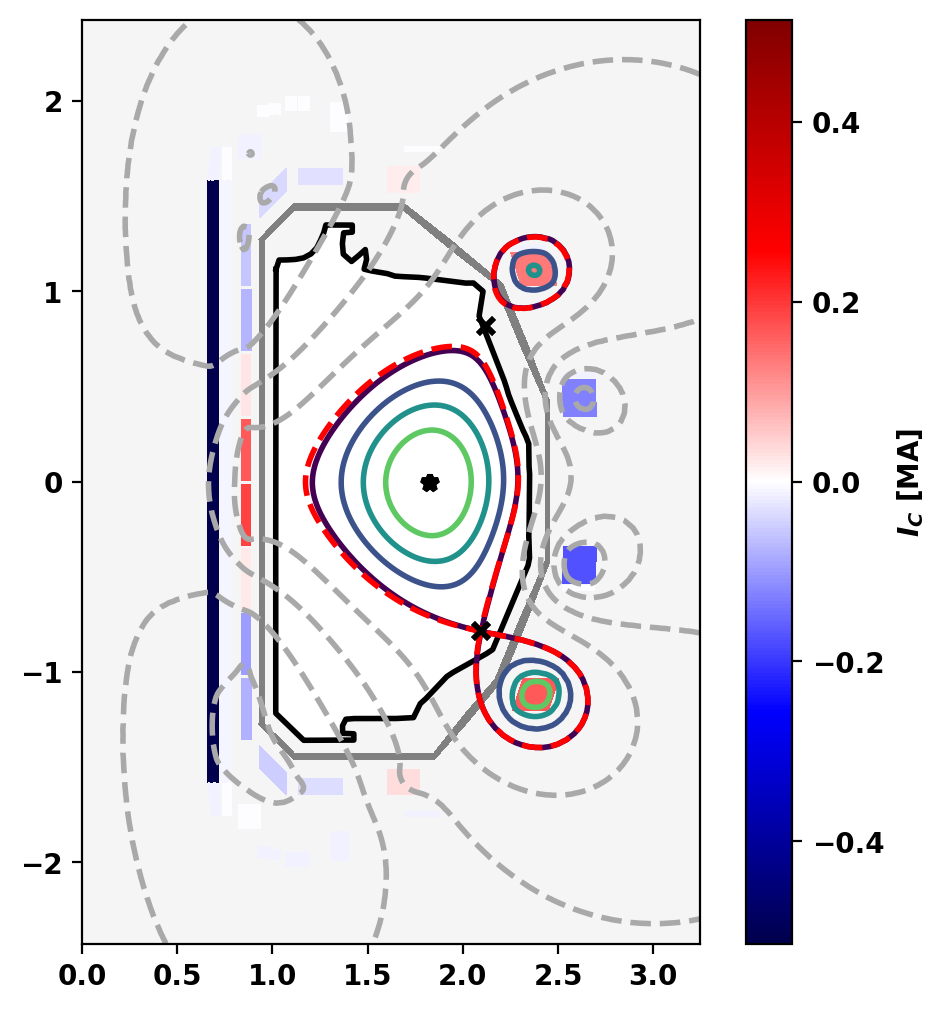

In [23]:
# Plot first case surfaces
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]',coil_symmap=True)
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_psi(fig,ax,psi_target,plasma_levels=[1.0,],plasma_color='red',vacuum_nlevels=0,plasma_linestyles='dashed')

plt.show()

### Perform reconstruction

In [24]:
# Remove all shape constraints
mygs.set_isoflux(None)
mygs.set_flux(None,None)
mygs.set_saddles(None)

# Set initial position targets from current values
mygs.set_targets(R0=mygs.o_point[0],V0=mygs.o_point[1])

# Set reconstruction settings
myrecon.settings.fitPnorm = False
myrecon.settings.fitR0 = True
myrecon.settings.fitCoils = True
myrecon.settings.pm = False

# Perform reconstructions
err_flag = myrecon.reconstruct()


*** Loading fit constraints ***
 Fixed           0           0

Starting Fit:
  # of free parameters   =   22
  # of constraints       =   93

Function evaluation    1
  Alam              =  3.598E+00
  P_scale           =  1.379E-01
  R0_target         =  1.829E+00
  V0_target         = -5.376E-03
  Coil currents [%]  =  0.000E+00  0.000E+00 -0.000E+00 -0.000E+00 -0.000E+00 -0.000E+00  0.000E+00 -0.000E+00  0.000E+00  0.000E+00  0.000E+00 -0.000E+00 -0.000E+00 -0.000E+00 -0.000E+00  0.000E+00 -0.000E+00  0.000E+00 -0.000E+00 -0.000E+00
  Maximum Rel Error =  6.734E-01
  Maximum Abs Error =  7.723E+00
  Total Weighted Error   =  1.908E+01
  RMS Weighted Error     =  1.978E+00

Function evaluation    2
  Alam              =  3.598E+00
  P_scale           =  1.379E-01
  R0_target         =  1.829E+00
  V0_target         = -5.376E-03
  Coil currents [%]  =  0.000E+00  0.000E+00 -0.000E+00 -0.000E+00 -0.000E+00 -0.000E+00  0.000E+00 -0.000E+00  0.000E+00  0.000E+00  0.000E+00 -0.000E+00 -

### Print equilibrium information and coil currents
As above we use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.print_info "print_info()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_coil_currents "get_coil_currents()" to display information on the final equilibrium.

In [25]:
mygs.print_info()

print()
print("Coil Currents [MA]:")
coil_currents, _ = mygs.get_coil_currents()
for key, current in coil_currents.items():
    print('  {0:10} {1:10.2F}'.format(key+":",current/1.E6))

Equilibrium Statistics:
  Topology                =   Diverted
  Toroidal Current [A]    =    4.8845E+05
  Current Centroid [m]    =    1.783 -0.007
  Magnetic Axis [m]       =    1.809 -0.005
  Elongation              =    1.338 (U:  1.253, L:  1.423)
  Triangularity           =   -0.498 (U: -0.346, L: -0.650)
  Plasma Volume [m^3]     =   12.891
  q_0, q_95               =    1.449  4.385
  Peak Pressure [Pa]      =    6.5064E+03
  Stored Energy [J]       =    4.0018E+04
  <Beta_pol> [%]          =   21.2385
  <Beta_tor> [%]          =    0.1488
  <Beta_n>   [%]          =    0.3128
  Diamagnetic flux [Wb]   =    6.1793E-03
  Toroidal flux [Wb]      =    2.1524E+00
  l_i                     =    1.1607

Coil Currents [MA]:
  F1A:             0.16
  F2A:             0.03
  F3A:            -0.08
  F4A:            -0.06
  F5A:            -0.04
  F6A:            -0.13
  F7A:             0.13
  F8A:            -0.03
  F9A:             0.02
  F1B:             0.18
  F2B:             0.02
 

### Plot final reconstructed equilibrium

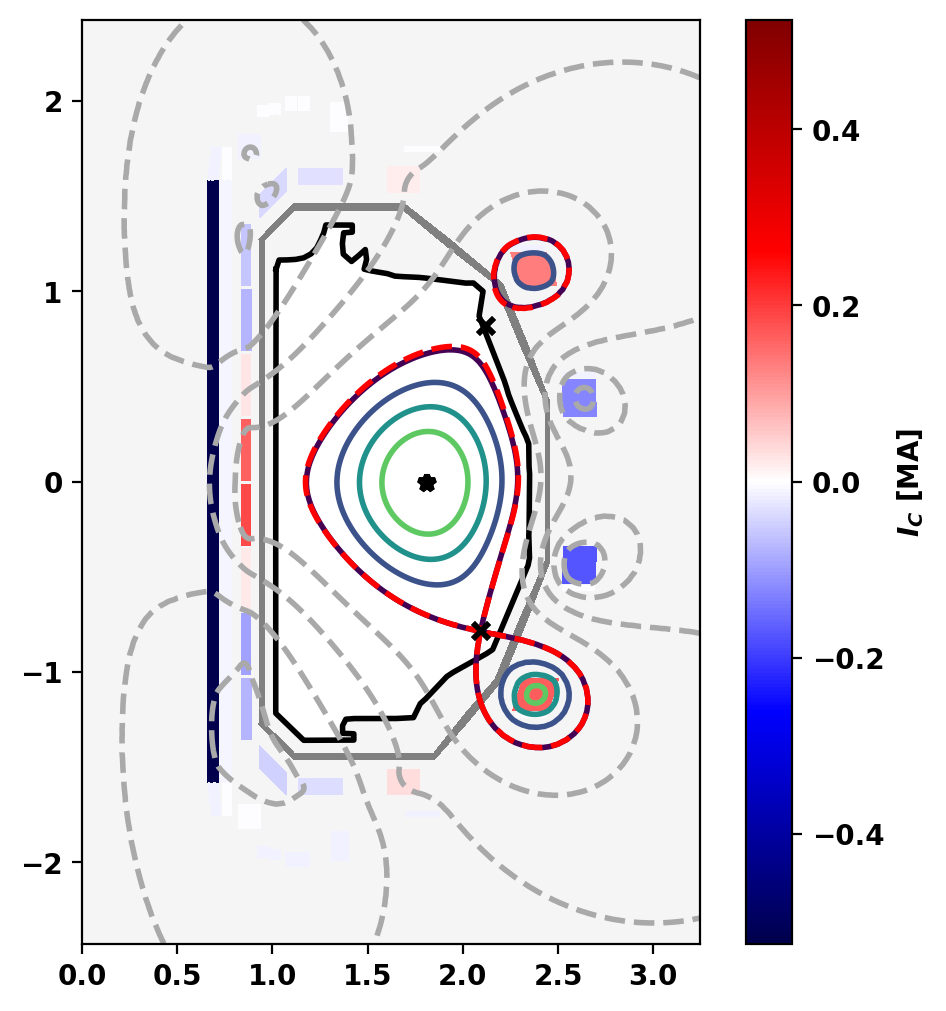

In [26]:
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]',coil_symmap=True)
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_psi(fig,ax,psi_target,plasma_levels=[1.0,],plasma_color='red',vacuum_nlevels=0,plasma_linestyles='dashed')

plt.show()